# 19대 젠더 관련 의안 분석

### 2012.05.30 ~ 2016.05.29 / 이명박 박근혜 정부

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [3]:
bill_df1 = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/19대 국회 의안정보(1).csv', 
                      parse_dates=['제안일자', '의결일자'])
bill_df2 = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/19대 국회 의안정보(2).csv', 
                      parse_dates=['제안일자', '의결일자'])

bill_df = pd.concat([bill_df1, bill_df2]).drop_duplicates()
bill_df.shape

(17822, 10)

In [4]:
def preprocessing(text): 
    text = text.replace('■ 주요내용', ' ').replace('■ 주요골자', ' ').replace('■ 기타사항', ' ').replace('■ 제안경위', ' ')
    text = text.replace('제안이유',' ').replace('주요내용',' ').replace('[',' ').replace(']',' ')
    text = text.replace('참고사항', ' ').replace('■ 위원회 수정이유', ' ').replace('■ 위원회 수정주요내용',' ')
    text = text.replace("'",' ').replace('□ 수정이유',' ').replace('주요골자', ' ').replace('■ 수정사항',' ')
    return text

def clean_name(text): 
    text = text.split('(')[0]
    return text.strip()

In [5]:
%time bill_df['제안이유'] = bill_df['제안이유'].apply(preprocessing)
%time bill_df['의안명'] = bill_df['의안명'].apply(clean_name)

CPU times: user 133 ms, sys: 9.95 ms, total: 143 ms
Wall time: 154 ms
CPU times: user 10.4 ms, sys: 471 µs, total: 10.8 ms
Wall time: 11 ms


## 젠더 관련 의안만 추리기

In [6]:
# 여성가족위원회와 아동·여성대상 성폭력 대책 특별위원회!
bill_df['소관위원회'].unique()

array(['교육문화체육관광위원회', '환경노동위원회', '안전행정위원회', '농림축산식품해양수산위원회', '법제사법위원회',
       '여성가족위원회', '보건복지위원회', '정무위원회', '국방위원회', '기획재정위원회', '산업통상자원위원회',
       '국토교통위원회', '미래창조과학방송통신위원회', '외교통일위원회', '정보위원회', '국회운영위원회',
       '정치개혁 특별위원회', '공적연금 강화와 노후빈곤 해소를 위한 특별위원회', nan, '공무원연금개혁 특별위원회',
       '국가정보원등 국가기관의 정치적 중립성 강화를 위한 제도개선 특별위원회', '문화체육관광방송통신위원회',
       '행정안전위원회', '지식경제위원회', '교육과학기술위원회', '국토해양위원회', '농림수산식품위원회',
       '외교통상통일위원회', '아동·여성대상 성폭력 대책 특별위원회'], dtype=object)

In [7]:
comm = bill_df[(bill_df['소관위원회'] == '여성가족위원회')|(bill_df['소관위원회'] == '아동·여성대상 성폭력 대책 특별위원회')]
comm['의안명'].unique()

array(['건강가정기본법 일부개정법률안', '아동·청소년의 성보호에 관한 법률 일부개정법률안',
       '청소년활동 진흥법 일부개정법률안', '청소년복지 지원법 일부개정법률안', '아이돌봄 지원법 일부개정법률안',
       '청소년 기본법 일부개정법률안', '다문화가족지원법 일부개정법률안', '청소년 보호법 일부개정법률안',
       '결혼중개업의 관리에 관한 법률 일부개정법률안', '한국청소년연맹 육성에 관한 법률 일부개정법률안',
       '학교 밖 청소년 지원에 관한 법률 일부개정법률안', '한부모가족지원법 일부개정법률안',
       '양육비 이행확보 및 지원에 관한 법률 일부개정법률안', '양성평등기본법 일부개정법률안',
       '경력단절여성등의 경제활동 촉진법 일부개정법률안', '성폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안',
       '가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안',
       '일제하 일본군위안부 피해자에 대한 생활안정지원 및 기념사업 등에 관한 법률 일부개정법률안',
       '성매매방지 및 피해자보호 등에 관한 법률 일부개정법률안', '경력단절여성등의 경제활동 촉진법 전부개정법률안',
       '여성발전기본법 일부개정법률안', '성차별ㆍ성희롱 금지 및 권리구제 등에 관한 법률안',
       '스카우트활동 육성에 관한 법률 일부개정법률안', '가족친화 사회환경의 조성 촉진에 관한 법률 일부개정법률안',
       '성별영향분석평가법 일부개정법률안', '청소년활동진흥법 일부개정법률안', '학교 밖 청소년 지원에 관한 법률안',
       '여성발전기본법 전부개정법률안', '청년발전기본법안', '성매매방지 및 피해자보호 등에 관한 법률 전부개정법률안',
       '양육비 이행확보 및 지원에 관한 법률안', '청소년기본법 일부개정법률안', '학교 밖 청소년 지원법안',
       '성차별ㆍ성희롱금지 및 권리구제 등에 관한 법률안', '인신매매등에 의한 피해자보

In [8]:
keyword = r'.*(여성|성범죄|남녀|호주|육아|보육|가부장|강간|간통죄|성폭력|남녀평등|성차별|모성|성접대|낙태|부녀자|퇴폐|남여|미혼모|포르노|웹하드|기지촌|\
                성희롱|성보호|음란|윤락|위안부|몸캠|양성평등|복제물|양성 평등|스토킹|가정폭력|정신대|청소년|가정폭력|남녀차별|모자보건|출산|모부자|\
                공중화장실|공중 화장실|건강가족기본법|유산|사산|성인지|한부모|모·부자|건강가정|돌봄|성별|다문화|위치추적|몰카|몰래카메라|미투|그루밍|\
                사이버범죄|카르텔|가사노동|가사 노동|결혼중개업|비혼|양육비|가족친화|건전가정|조손가족|가족관계|인신매매|가족법|여교수|산전휴휴가|건강가정).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender.shape

(2040, 11)

In [9]:
keyword = r'.*(유리천장).*'
glass = gender[gender['의안명'].str.match(keyword) |
           gender['제안이유'].str.match(keyword, flags=re.MULTILINE)]
glass = glass.reset_index()
glass.shape

(3, 12)

In [35]:
# 강간의 범위를 남성피해자도 넓힌다는 것 -> 젠더관련의안인가? 
gender[(gender['의안번호'] == 1800738) | (gender['의안번호'] == 1800582)]

,index,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자


In [10]:
for ind in range(1500, len(gender)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '의안명'])
    print(gender.loc[ind, '제안이유'])

1903963
남북교류특별구역의 지정 및 운영에 관한 법률안
   남북 간의 교류활동은 현재의 이익을 넘어서 한반도 공동체를 실현을 위한 중요한 수단이나 대부분 경제적인 분야에 치중되어 있고 정치적 상황 및 주변 정세 등에 따라 교류의 지속성이 담보되지 못하여 상호간의 이해 부족으로 공동체를 이루기 위한 사회문화적 기반 마련이 어려운 실정임. 또한 분단이후 상당한 시간이 흘러 자라나는 청소년 세대에서 통일의 당위성에 대한 인식이 점점 약해지고 있어 상호 교류의 필요성이 높아지고 있음.이에 남북교류의 지속성을 담보하고 제도적으로 활성화하기 위하여 정치적 이해관계 등으로부터 자유로운 중립지역으로서의 특별구역을 설치함으로써 남북 간 상호이해를 도모하기 위한 기반을 마련하고 동질성을 회복하여 장기적 관점에서 통일에 대한 준비를 하고자 함. 가. 남한과 북한 간의 상호 교류 및 협력의 촉진을 위하여 남북교류특별구역의 지정에 관한 사항을 규정함(안 제1조).나. 남북교류특별구역의 지정ㆍ운영에 관하여 다른 법률에 우선하여 적용하되, 이 법에 의한 남북교류특별구역개발계획은 다른 법령에 의한 계획을 충분히 고려해야 함을 규정함(안 제3조).다. 이 법의 목적을 달성하기 위하여 대통령 소속으로 남북교류특별구역위원회를 두고, 남북교류특별구역위원회는 남북교류특별구역에 설치하며, 인접지역을 관할하는 시장ㆍ군수는 남북교류특별구역개발계획을 제출하여 남북교류특별구역의 지정을 남북교류특별구역위원회에 요청할 수 있도록 함(안 제4조 및 제19조).라. 남북교류특별구역의 지정이 있는 때에는 해당 남북교류특별구역의 내용에 따른 지정ㆍ수립ㆍ심의ㆍ협의 또는 승인이 각각 성립된 것으로 간주함(안 제8조).마. 남북교류특별구역위원회의 남북교류특별구역 안에서 발생하는 각종 사무를 처리하게 하기 위하여 남북교류특별구역관리청을 둠(안 제20조).바. 남북한 청소년간 상호이해를 높이고 동질성을 회복하기 위하여 남북청소년교류센터를 설치함(안 제24조).사. 남북한 간의 물자교역？협력 사업 등을 촉진하기 위하여 

In [9]:
remove_bill = [1918707, 1918706, 1918675, 1918653, 1918606, 1918584, 1918578, 1918577, 1918546, 1918545, 1918536, 
               1918525, 1918522, 1918521, 1918520, 1918519, 1918518, 1918486, 1918478, 1918460, 1918449, 1918434, 
               1918415, 1918396, 1918375, 1918373, 1918358, 1918355, 1918334, 1918315, 1918313, 1918312, 1918272, 
               1918251, 1918224, 1918198, 1918191, 1918187, 1918169, 1918165, 1918154, 1918148, 1918140, 1918131, 
               1918125, 1918116, 1918113, 1918112, 1918055, 1918040, 1918006, 1918002, 1917915, 1917909, 1917908, 
               1917867, 1917865, 1917851, 1917844, 1917828, 1917817, 1917809, 1917755, 1917727, 1917722, 1917694, 
               1917685, 1917678, 1917675, 1917648, 1917633, 1917629, 1917620, 1917598, 1917593, 1917571, 1917567, 
               1917545, 1917540, 1917536, 1917527, 1917526, 1917523, 1917429, 1917407, 1917303, 1917292, 1917265, 
               1917264, 1917193, 1917192, 1917174, 1917168, 1917121, 1917112, 1917049, 1917031, 1917023, 1916987, 
               1916934, 1916922, 1918112, 1918055, 1918040, 1918006, 1918002, 1917927, 1917909, 1917908, 1917867, 
               1917865, 1917851, 1917844, 1917828, 1917817, 1917809, 1917804, 1917755, 1917727, 1917722, 1917694, 
               1917678, 1917675, 1917648, 1917633, 1917629, 1917620, 1917598, 1917571, 1917567, 1917540, 1917536, 
               1917527, 1917526, 1917523, 1917472, 1917470, 1917429, 1917407, 1917344, 1917334, 1917303, 1917292, 
               1917284, 1917265, 1917264, 1917193, 1917192, 1917174, 1917168, 1917121, 1917112, 1917049, 1917031, 
               1917023, 1916988, 1916987, 1916922, 1916918, 1916891, 1916879, 1916858, 1916833, 1916819, 1916805, 
               1916799, 1916763, 1916734, 1916684, 1916671, 1916670, 1916668, 1916662, 1916659, 1916640, 1916630, 
               1916570, 1916517, 1916509, 1916506, 1916491, 1916475, 1916418, 1916385, 1916372, 1916369, 1916367, 
               1916356, 1916355, 1916351, 1916342, 1916331, 1916306, 1916294, 1916214, 1916187, 1916165, 1916152, 
               1916143, 1916135, 1916122, 1916090, 1916080, 1916054, 1916022, 1915983, 1915980, 1915969, 1915966, 
               1915922, 1915891, 1915814, 1915814, 1915813, 1915812, 1915770, 1915749, 1915744, 1915721, 1915720, 
               1915691, 1915684, 1915682, 1915669, 1915657, 1915609, 1915595, 1915547, 1915538, 1915502, 1915490, 
               1915473, 1915457, 1915453, 1915364, 1915358, 1915356, 1915348, 1915326, 1915314, 1915297, 1915293, 
               1915292, 1915288, 1915287, 1915180, 1915173, 1915172, 1915171, 1915170, 1915160, 1915136, 1915092, 
               1915076, 1915065, 1915043, 1915034, 1914998, 1914991, 1914988, 1914969, 1914965, 1914961, 1914932, 
               1914867, 1914820, 1914808, 1914796, 1914785, 1914697, 1914693, 1914690, 1914688, 1914672, 1914643, 
               1914600, 1914577, 1914560, 1914533, 1914510, 1914477, 1914476, 1914460, 1914445, 1914423, 1914400, 
               1914384, 1914342, 1914291, 1914260, 1914236, 1914174, 1914171, 1914136, 1914133, 1914122, 1914048, 
               1914037, 1914020, 1914008, 1913964, 1913947, 1913936, 1913934, 1913916, 1913915, 1913905, 1913903, 
               1913902, 1913896,
               1913895, 1913881, 1913855, 1913850, 1913846, 1913817, 1913809, 1913795, 1913789, 1913784, 1913781, 
               1913777, 1913773, 1913748, 1913738, 1913723, 1913719, 1913705, 1913695, 1913640, 1913613, 1913577, 
               1913569, 1913566, 1913535, 1913521, 1913476, 1913441, 1913411, 1913398, 1913376, 1913358, 1913329, 
               1913316, 1913315, 1913229, 1913197, 1913171, 1913166, 1913130, 1913120, 1913089, 1913055, 1913054, 
               1913011, 1912987, 1912962, 1912943, 1912873, 1912854, 1912849, 1912839, 1912801, 1912800, 1912788, 
               1912783, 1912767, 1912764, 1912714, 1912713, 1912663, 1912653, 1912640, 1912636, 1912606, 1912587, 
               1912574, 1912543, 1912525, 1912512, 1912497, 1912487, 1912479, 1912476, 1912458, 1912456, 1912448, 
               1912420, 1912416, 1912345, 1912341, 1912340, 1912339, 1912338, 1912337, 1912319, 1912318, 1912305, 
               1912260, 1912257, 1912242, 1912215, 1912197, 1912194, 1912165, 1912164, 1912163, 1912149, 1912046, 
               1912020, 1911993, 1911988, 1911973, 1911951, 1911926, 1911898, 1911889, 1911881, 1911876, 1911856, 
               1911848, 1911844, 1911823, 1911813, 1911803, 1911796, 1911791, 1911700, 1911699, 1911698, 1911696, 
               1911695, 1911665, 1911636, 1911599, 1911598, 1911569, 1911551, 1911541, 1911527, 1911488, 1911474, 
               1911464, 1911450, 1911441, 1911431, 1911422, 1911399, 1911352, 1911319, 1911314, 1911295, 1911285, 
               1911276, 1911261, 1911256, 1911249, 1911247, 1911227, 1911182, 1911178, 1911166, 1911126, 1911123, 
               1911121, 1911103, 1911083, 1911082, 1911060, 1911057, 1911002, 1910965, 1910943, 1910937, 1910868,
               1910853, 1910846, 1910772, 1910752, 1910741, 1910679, 1910678, 1910674, 1910584, 1910579, 1910573, 
               1910528, 1910518, 1910499, 1910497, 1910477, 1910473, 1910457, 1910437, 1910382, 1910381, 1910357, 
               1910344, 1910310, 1910306, 1910300, 1910277, 1910244, 1910220, 1910189, 1910180, 1910155, 1910110, 
               1910078, 1910028, 1910017, 1910016, 1910015, 1909924, 1909916, 1909890, 1909861, 1909850, 1909835, 
               1909812, 1909751, 1909701, 1909681, 1909675, 1909659, 1909658, 1909625, 1909620, 1909608, 1909592, 
               1909587, 1909582, 1909575, 1909561, 1909536, 1909530, 1909528, 1909523, 1909486, 1909473, 1909387, 
               1909379, 1909372, 1909355, 1909353, 1909350, 1909335, 1909329, 1909317, 1909259, 1909209, 1909159, 
               1909100, 1909096, 1909077, 1909015, 1909000, 1908954, 1908953, 1908938, 1908891, 1908851, 1908824, 
               1908793, 1908771, 1908730, 1908706, 1908660, 1908655, 1908584, 1908579, 1908562, 1908533, 1908529,
               1908525, 1908490, 1908489, 1908488, 1908439, 1908437, 1908425, 1908424, 1908419, 1908418, 1908397, 
               1908376, 1908308, 1908285, 1908253, 1908250, 1908249, 1908238, 1908237, 1908108, 1908083, 1908081, 
               1908080, 1908078, 1908021, 1907991, 1907932, 1907892, 1907837, 1907817, 1907766, 1907743, 1907689, 
               1907675, 1907672, 1907668, 1907640, 1907582, 1907503, 1907446, 1907339, 1907332, 1907309, 1907286, 
               1907254, 1907248, 1907243, 1907238, 1907180, 1907154, 1907116, 1907115, 1907099, 1907077, 1907063, 
               1907061, 1907029, 1906967, 1906951, 1906950, 1906946, 1906935, 1906925, 1906924, 1906915, 1906909, 
               1906875, 1906873, 1906867, 1906831, 1906797, 1906756, 1906738, 1906722, 1906717, 1906701, 1906687, 
               1906666, 1906650, 1906639, 1906638, 1906619, 1906616, 1906613, 1906604, 1906593, 1906583, 1906580, 
               1906578, 1906559, 1906557, 1906551, 1906531, 1906509, 1906503, 1906494, 1906493, 1906432, 1906410, 
               1906407, 1906393, 1906367, 1906312, 1906294, 1906281, 1906250, 1906232, 1906204, 1906173, 1906128, 
               1906123, 1906105, 1906102, 1906088, 1906080, 1906070, 1906068, 1906053, 1906042, 1906031, 1906023, 
               1906001, 1905976, 1905975, 1905972, 1905971, 1905870, 1905845, 1905794, 1905784, 1905783, 1905719, 
               1905718, 1905717, 1905716, 1905710, 1905706, 1905699, 1905696, 1905695, 1905676, 1905669, 1905647, 
               1905646, 1905630, 1905565, 1905564, 1905550, 1905535, 1905509, 1905499, 1905493, 1905482, 1905473, 
               1905440, 1905409, 1905358, 1905356, 1905355, 1905337, 1905299, 1905280, 1905250, 1905245, 1905236, 
               1905234, 1905228, 1905209, 1905207, 1905191, 1905184, 1905183, 1905147, 1905128, 1905114, 1905112, 
               1905111, 1905104, 1905062, 1905059, 1905056, 1905052, 1905051, 1905035, 1905000, 1904981, 1904955, 
               1904928, 1904890, 1904878, 1904876, 1904868, 1904867, 1904865, 1904842, 1904799, 1904757, 1904741, 
               1904732, 1904725, 1904719, 1904718, 1904692, 1904687, 1904598, 1904591, 1904589, 1904580, 1904560, 
               1904533, 1904505, 1904490, 1904487, 1904474, 1904470, 1904411, 1904410, 1904401, 1904396, 1904381, 
               1904380, 1904326, 1904310, 1904276, 1904263, 1904247, 1904245, 1904228, 1904220, 1904218, 1904216, 
               1904212, 1904198, 1904187, 1904184, 1904177, 1904117, 1904108, 1904089, 1904046, 1903996, 1903989,
               1905845, 1903963, 1903916, 1903915, 1903887, 1903798, 1903797, 1903783, 1903760, 1903731, 1903710, 
               1903658, 1903630, 1903618, 1903592, 1903587, 1903580, 1903567, 1903559, 1903550, 1903549, 1903541, 
               1903536, 1903466, 1903462, 1903437, 1903426, 1903398, 1903385, 1903379, 1903378, 1903353, 1903349, 
               1903340, 1903339, 1903334, 1903333, 1903331, 1903319, 1903314, 1903307, 1903300, 1903294, 1903283, 
               1903276, 1903264, 1903263, 1903262, 1903259, 1903246, 1903232, 1903213, 1903208, 1903201, 1903164, 
               1903128, 1903087, 1903055, 1903044, 1903031, 1903023, 1903015, 1902972, 1902967, 1902961, 1902952, 
               1902951, 1902914, 1902911, 1902907, 1902904, 1902899, 1902886, 1902883, 1902880, 1902877, 1902876, 
               1902875, 1902829, 1902817, 1902811, 1902809, 1902784, 1902775, 1902772, 1902682, 1902670, 1902660, 
               1902654, 1902650, 1902639, 1902630, 1902622, 1902588, 1902570, 1902568, 1902567, 1902543, 1902522, 
               1902504, 1902484, 1902483, 1902482, 1902480, 1902377, 1902344, 1902337, 1902336, 1902330, 1902323, 
               1902301, 1902298, 1902264, 1902254, 1902253, 1902251, 1902250, 1902236, 1902219, 1902212, 1902207, 
               1902191, 1902186, 1902178, 1902173, 1902161, 1902141, 1902129, 1902127, 1902120, 1902108, 1902080, 
               1902070, 1902042, 1902021, 1901988, 1901970, 1901961, 1901948, 1901942, 1901906, 1901905, 1901904, 
               1901887, 1901886, 1901884, 1901883, 1901869, 1901854, 1901852, 1901835, 1901823, 1901780, 1901755, 
               1901739, 1901720, 1901699, 1901692, 1901691, 1901651, 1901646, 1901562, 1901465, 1901464, 1901457, 
               1901453, 1901442, 1901421, 1901419, 1901372, 1901362, 1901358, 1901356, 1901287, 1901285, 1901278, 
               1901273, 1901257, 1901235, 1901172, 1901159, 1901087, 1901062, 1901061, 1901059, 1901052, 1901039,
               1901032, 1901022, 1901000, 1900996, 1900984, 1900951, 1900950, 1900926, 1900895, 1900850, 1900730, 
               1900664, 1900663, 1900655, 1900647, 1900597, 1900546, 1900545, 1900509, 1900474, 1900470, 1900468, 
               1900440, 1900437, 1900436, 1900430, 1900391, 1900389, 1900370, 1900306, 1900289, 1900282, 1900279, 
               1900261, 1900236, 1900185, 1900159, 1900158, 1900144, 1900121, 1900075, 1900043, 1900040, 1900001]
gender = gender[~gender['의안번호'].isin(remove_bill)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(1044, 11)

In [17]:
list1 = set(gender['의안번호'].values)
list2 = set(gender2['의안번호'].values)

In [19]:
common = list1 & list2

In [21]:
left = list2 - common

In [25]:
new_list = list(left)
gender3 = gender2[~gender2['의안번호'].isin(new_list)]

In [26]:
for ind in range(0, len(gender3)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '의안명'])
    print(gender.loc[ind, '제안이유'])

1918726
유아교육법 일부개정법률안
  1.  최근 보육기관에서 아동학대 사건이 잇달아 발생하고 있는 가운데 아동학대 근절과 행복한 학교문화에 대한 관심이 제기되고 있음. 이에 안전하고 행복한 유치원 문화를 조성하기 위해 유아에 대한 체벌을 하지 않도록 하고 헌법과 국제인권조약에 명시된 유아의 학생인권을 보장하고자 함.또한 아동학대로부터 안전한 유치원 및 유아 교육과정을 위하여 유치원의 원장 또는 설립ㆍ경영자가 아동학대 행위를 하거나 교직원 등 원장 또는 설립ㆍ경영자의 관리ㆍ감독 하에 있는 자가 아동학대 행위를 하여 유치원의 정상적인 교육과정 운영이 불가능한 경우에는 국립유치원의 경우에는 교육부장관이, 공ㆍ사립유치원의 경우에는 교육감이 각각 해당 유치원의 폐쇄를 명할 수 있도록 하려는 것임.한편, 지금까지는 유치원에 입학할 유아를 선발할 때에 유치원의 장은 교육 목적에 적합한 범위에서 유치원규칙으로 정하는 바에 따라 공정하고 투명한 방법으로 선발하도록 하는 내용을 대통령령에 규정하고 있었으나, 앞으로는 이에 대한 근거를 법률로 상향하여 규정하면서 유치원에 입학할 유아의 모집ㆍ선발 시기, 절차 및 방법 등에 관하여 지방자치단체가 조례로 달리 정한 것이 있는 경우 원장은 이에 따라 유아를 모집ㆍ선발하도록 하여 유아의 교육 기회를 균등하게 보장할 수 있는 장치를 마련하는 등 현행 제도의 운영상 나타난 일부 미비점을 개선ㆍ보완하려는 것임.2.  가. 유치원규칙에 대한 별도 인가 절차 폐지(안 제10조)나. 유아모집, 시기에 관한 사항의 조례 위임(안 제11조)다. 외국인유치원에 적용이 예외되는 규정 추가(안 제16조)라. 유치원 설립자ㆍ경영자와 원장의 유아 인권보장 의무 및 체벌 금지 조항 신설(안 제21조의2)마. 아동학대가 발생한 유치원에 대한 운영정지 및 폐쇄 명령 신설(안 제32조)  
1918721
초·중등교육법 일부개정법률안
  1.  학교운영위원회 위원의 결격사유를 강화하고, 법정형을 정비하려는 것임.2.  성폭력 범죄 등의 처벌 경력이 있는 경우를 

In [ ]:
1918726, 1918657, 1918656, 1918655, 1918654, 1918607, 1918496, 1918439, 1918426, 1918328,  


In [10]:
keyword = r'.*(카르텔|과다노출|사이버 범죄|몰래카메라|몰카|불법 촬영|몸캠|성폭력|성착취|성매매|성범죄|\
                버닝썬|성희롱|딥페이크|복제물|음란|성범죄|n번방|웹하드|촬영물|클럽|성접대|미투|그루밍|성희롱).*'
gender2 = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender2 = gender2[~gender2['의안번호'].isin(remove_bill)]
gender2.shape

(408, 10)

In [44]:
len(remove_bill)

1047

In [12]:
gender.to_csv('19th-gender-bill.csv',encoding='utf-8-sig')

## wordcloud 시각화

In [13]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [14]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [15]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 61.2 ms, sys: 1.41 ms, total: 62.6 ms
Wall time: 61.6 ms


In [16]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [17]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 53.4 s, sys: 731 ms, total: 54.1 s
Wall time: 42 s


0    [유아교육법, 일부개정법률안, 보육기관, 아동학대, 사건, 발생, 가운데, 아동학대...
1    [중등교육법, 일부개정법률안, 학교운영위원회, 위원, 결격사유, 강화, 법정형, 정...
2    [건강가정기본법, 일부개정법률안, 국가, 지방자치단체, 모성보호, 부성보호, 명시,...
Name: tokens, dtype: object

In [18]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 238 ms, sys: 3.1 ms, total: 241 ms
Wall time: 241 ms


In [19]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [20]:
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-23 17:13:32,319 : INFO : collecting all words and their counts
2020-09-23 17:13:32,321 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-23 17:13:32,340 : INFO : collected 10321 word types from a corpus of 93196 raw words and 1044 sentences
2020-09-23 17:13:32,341 : INFO : Loading a fresh vocabulary
2020-09-23 17:13:32,350 : INFO : effective_min_count=10 retains 1548 unique words (14% of original 10321, drops 8773)
2020-09-23 17:13:32,350 : INFO : effective_min_count=10 leaves 72862 word corpus (78% of original 93196, drops 20334)
2020-09-23 17:13:32,355 : INFO : deleting the raw counts dictionary of 10321 items
2020-09-23 17:13:32,356 : INFO : sample=0.001 downsamples 55 most-common words
2020-09-23 17:13:32,357 : INFO : downsampling leaves estimated 62978 word corpus (86.4% of prior 72862)
2020-09-23 17:13:32,362 : INFO : estimated required memory for 1548 words and 100 dimensions: 2012400 bytes
2020-09-23 17:13:32,363 : INFO : resetting layer

2020-09-23 17:13:33,677 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:33,682 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:33,685 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:33,686 : INFO : EPOCH - 15 : training on 93196 raw words (63060 effective words) took 0.1s, 1055872 effective words/s
2020-09-23 17:13:33,744 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:33,746 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:33,749 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:33,756 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:33,757 : INFO : EPOCH - 16 : training on 93196 raw words (62991 effective words) took 0.1s, 965086 effective words/s
2020-09-23 17:13:33,808 : INFO : worker thread finished; awaiting finish of 3 more threads
202

2020-09-23 17:13:34,626 : INFO : EPOCH - 31 : training on 93196 raw words (62897 effective words) took 0.0s, 1351475 effective words/s
2020-09-23 17:13:34,669 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:34,670 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:34,672 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:34,675 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:34,676 : INFO : EPOCH - 32 : training on 93196 raw words (63071 effective words) took 0.0s, 1353089 effective words/s
2020-09-23 17:13:34,720 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:34,722 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:34,723 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:34,729 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-09-23 17:13:35,521 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:35,522 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:35,526 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:35,526 : INFO : EPOCH - 48 : training on 93196 raw words (62974 effective words) took 0.0s, 1398490 effective words/s
2020-09-23 17:13:35,568 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:35,570 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:35,572 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:35,575 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:35,576 : INFO : EPOCH - 49 : training on 93196 raw words (63075 effective words) took 0.0s, 1425989 effective words/s
2020-09-23 17:13:35,617 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-23 17:13:36,332 : INFO : EPOCH - 64 : training on 93196 raw words (62875 effective words) took 0.0s, 1401825 effective words/s
2020-09-23 17:13:36,381 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:36,384 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:36,386 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:36,387 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:36,387 : INFO : EPOCH - 65 : training on 93196 raw words (63004 effective words) took 0.1s, 1195788 effective words/s
2020-09-23 17:13:36,430 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:36,432 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:36,433 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:36,436 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-09-23 17:13:37,173 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:37,174 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:37,178 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:37,178 : INFO : EPOCH - 81 : training on 93196 raw words (63036 effective words) took 0.0s, 1483600 effective words/s
2020-09-23 17:13:37,219 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:37,223 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:37,224 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:37,227 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:37,227 : INFO : EPOCH - 82 : training on 93196 raw words (62944 effective words) took 0.0s, 1427597 effective words/s
2020-09-23 17:13:37,269 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-23 17:13:37,979 : INFO : EPOCH - 97 : training on 93196 raw words (63018 effective words) took 0.0s, 1443517 effective words/s
2020-09-23 17:13:38,019 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:38,022 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:38,024 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:38,026 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-23 17:13:38,027 : INFO : EPOCH - 98 : training on 93196 raw words (62960 effective words) took 0.0s, 1406779 effective words/s
2020-09-23 17:13:38,069 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-23 17:13:38,071 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-23 17:13:38,075 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-23 17:13:38,076 : INFO : worker thread finished; awaiting finish of 0 more threads
20

In [21]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

2020-09-23 17:13:38,133 : INFO : precomputing L2-norms of word weight vectors


[('고용률', 0.43457290530204773), ('격차', 0.428261935710907), ('경제활동', 0.4165613055229187), ('정치', 0.4087558090686798), ('경력단절여성등', 0.40635716915130615), ('개국', 0.39327728748321533), ('세계경제포럼', 0.3912546932697296), ('진출', 0.3807607889175415), ('분야', 0.379517138004303), ('남녀', 0.3679649233818054)]
[('아동', 0.675362229347229), ('청소년대상', 0.5359420776367188), ('성범죄자', 0.4574764370918274), ('성범죄', 0.44649192690849304), ('음란물', 0.4463199973106384), ('죄질', 0.4416278898715973), ('청소년들', 0.4334270656108856), ('처벌', 0.41905418038368225), ('청소년이용음란물', 0.41366803646087646), ('배포', 0.41319596767425537)]


In [22]:
gender['tokens']

0       [유아교육법, 일부개정법률안, 보육기관, 아동학대, 사건, 발생, 가운데, 아동학대...
1       [중등교육법, 일부개정법률안, 학교운영위원회, 위원, 결격사유, 강화, 법정형, 정...
2       [건강가정기본법, 일부개정법률안, 국가, 지방자치단체, 모성보호, 부성보호, 명시,...
3       [아동, 청소년, 성보호, 법률, 일부개정법률안, 성범죄자, 재범방지교육, 효과성,...
4       [주민등록법, 일부개정법률안, 주민등록번호, 유출, 발생, 피해, 국민, 불안감, ...
                              ...                        
1039    [모자보건법, 일부개정법률안, 우리나라, 합계출산율, 세계, 해당, 수치, 초저출산...
1040    [고용정책, 기본법, 일부개정법률안, 취업기회, 균등, 보장, 사업주, 근로자, 모...
1041    [영유아보육법, 일부개정법률안, 기준, 우리나라, 출산율, 세계, 최하위, 기록, ...
1042    [영유아보육법, 일부개정법률안, 현행, 정부, 보육료, 차례, 산정, 보육료, 기초...
1043    [소득세법, 일부개정법률안, 아동, 양육, 보육시설, 이용, 비용, 소득공제, 반면...
Name: tokens, Length: 1044, dtype: object

In [23]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [24]:
gender_word = total_tokens(gender['tokens'])

In [25]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','규정함','본회','수립','항제', '의결제','촉진','의결',
            '영역','도모','확대','구현','이외','원안폐','조등']
gender_word = [each_word for each_word in gender_word if each_word not in stopwords]

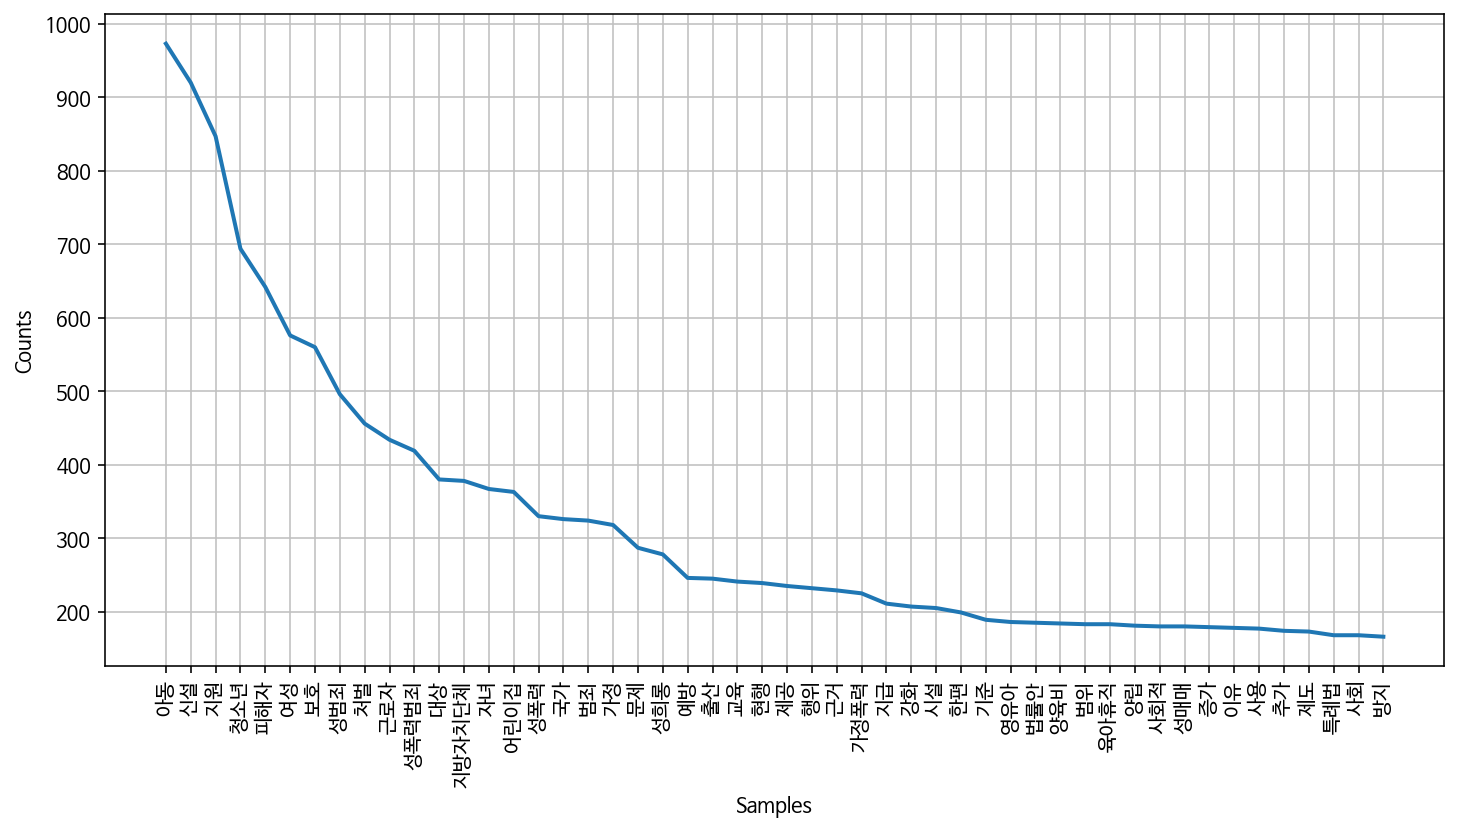

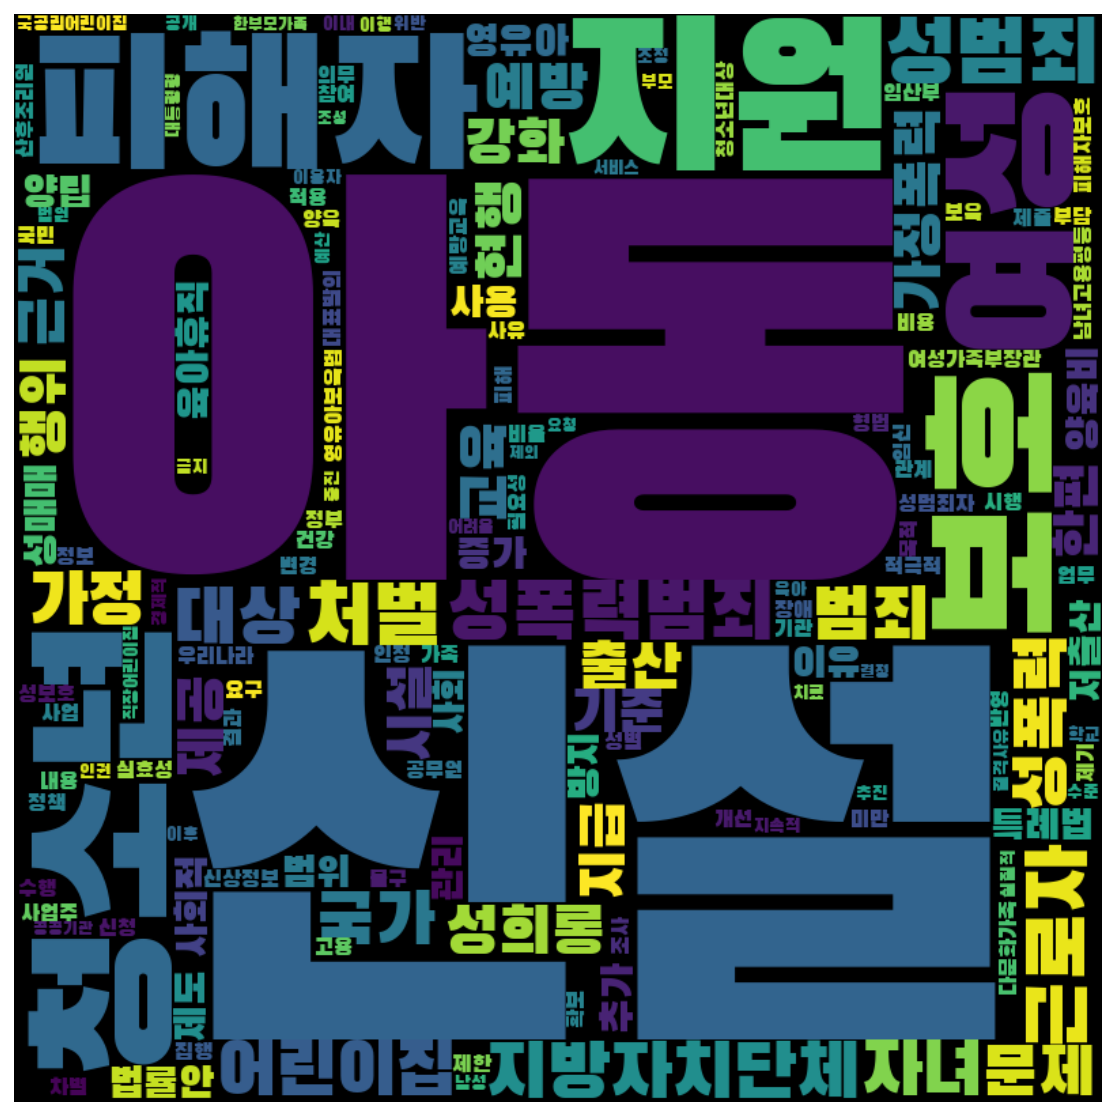

In [26]:
frewords_vis(gender_word)
wordcloud_vis(gender_word)